In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pwd

'/Users/robertkaiser/CodingProjects/Kaggle/Apr21Comp'

In [3]:
test = pd.read_csv('Data/test.csv')
#test.set_index('PassengerId', inplace = True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [4]:
train = pd.read_csv('Data/train.csv')
train.set_index('PassengerId', inplace = True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


## Explore Train Data

Aim is to look into the train data-set to find out trends and distributions

### Survival Rate

In [5]:
#Look at survivial rate
train['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [6]:
sum(train['Survived'])/len(train['Survived'])
#survival rate is 42%

0.42774

In [7]:
#Suvival by class
train.groupby('Pclass').apply(lambda x: sum(x['Survived'])/len(x))

Pclass
1    0.579779
2    0.525018
3    0.247305
dtype: float64

In [8]:
#Suvival by embarkment point
train.groupby('Embarked').apply(lambda x: sum(x['Survived'])/len(x))

#High rate in Southampton

Embarked
C    0.751296
Q    0.596976
S    0.315294
dtype: float64

In [9]:
train.groupby(['Embarked','Pclass']).apply(lambda x: len(x))

#High southampton rate potentially caused by prevelance of third class pasengers

Embarked  Pclass
C         1         11843
          2          6156
          3          4188
Q         1          3751
          2           844
          3           829
S         1         14635
          2         21609
          3         35895
dtype: int64

In [10]:
train['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [11]:
train.groupby('Sex').apply(lambda x: sum(x['Survived'])/len(x))

Sex
female    0.711525
male      0.205795
dtype: float64

In [12]:
train.groupby(['Pclass','Sex']).apply(lambda x: len(x))

Pclass  Sex   
1       female    16084
        male      14231
2       female    15283
        male      13396
3       female    12519
        male      28487
dtype: int64

In [13]:
train.groupby('SibSp').apply(lambda x: sum(x['Survived'])/len(x))


SibSp
0    0.426843
1    0.433748
2    0.453956
3    0.400000
4    0.375856
5    0.189394
8    0.385135
dtype: float64

## Correlation Plot

In [14]:
#Built quick cabin flag to indicate whether they had a cabin or not, may expand to build a "no cabin", "C Floor", "B Floor"... feature
train['CabinFlag'] = train['Cabin'].isna().astype('int')

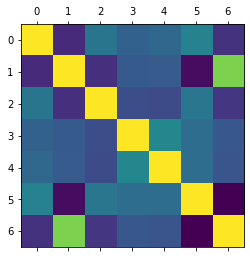

In [15]:
plt.matshow(train.corr())
plt.show()

In [16]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,CabinFlag
Survived,1.000000,-0.289723,0.103895,-0.007587,0.023352,0.187534,-0.251554
Pclass,-0.289723,1.000000,-0.259109,-0.051436,-0.041848,-0.417354,0.709274
Age,0.103895,-0.259109,1.000000,-0.112459,-0.125535,0.109164,-0.233788
SibSp,-0.007587,-0.051436,-0.112459,1.000000,0.213126,0.059358,-0.066946
Parch,0.023352,-0.041848,-0.125535,0.213126,1.000000,0.061443,-0.076096
Fare,0.187534,-0.417354,0.109164,0.059358,0.061443,1.000000,-0.464407
CabinFlag,-0.251554,0.709274,-0.233788,-0.066946,-0.076096,-0.464407,1.000000


In [17]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinFlag
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,0
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S,1
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,1
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,1
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1


## Perform Baskic feature engineering

In [18]:
y = train['Survived']

In [19]:
#impute Embarked NA columns
train['Embarked'].fillna('NA', inplace = True)

In [20]:
#impute Embarked NA columns
train['Embarked'].fillna('NA', inplace = True)
train['Pclass'] = train['Pclass'].astype('str')
train['CabinFlag'] = train['CabinFlag'].astype('str')
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

In [21]:
train['CabinLt'] = train['Cabin'].str[0]
train['CabinLt'].fillna('NA', inplace = True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinFlag,CabinLt
PassengerId,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,0,C
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S,1,NA
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,1,NA
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,1,NA
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1,NA


In [22]:
categoricals = ['Pclass', 'Sex', 'Embarked', 'CabinFlag', 'CabinLt']
trainCat = pd.get_dummies(train[categoricals])
trainCat.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S,CabinFlag_0,CabinFlag_1,CabinLt_A,CabinLt_B,CabinLt_C,CabinLt_D,CabinLt_E,CabinLt_F,CabinLt_G,CabinLt_NA,CabinLt_T
PassengerId,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [23]:
#need to imput fares and age, going to imput average per class, per embarkment point
train['Fare'] = train.groupby(['Pclass','Embarked', 'Sex'])['Fare'].transform(lambda x: x.fillna(x.mean()))
train['Age'] = train.groupby(['Pclass','Embarked', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinFlag,CabinLt
PassengerId,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,41.049623,2,0,209245,27.14,C12239,S,0,C
1,0,3,"Bryan, Drew",male,34.107378,0,0,27323,13.35,NaN,S,1,NA
2,0,3,"Owens, Kenneth",male,0.330000,1,2,CA 457703,71.29,NaN,S,1,NA
3,0,3,"Kramer, James",male,19.000000,0,0,A. 10866,13.04,NaN,S,1,NA
4,1,3,"Bond, Michael",male,25.000000,0,0,427635,7.76,NaN,S,1,NA


In [24]:
numericals = ['SibSp', 'Parch', 'Fare', 'Age', 'FamilySize']
trainNum = train[numericals]
trainNum.head()

,SibSp,Parch,Fare,Age
PassengerId,,,,
0,2,0,27.14,41.049623
1,0,0,13.35,34.107378
2,1,2,71.29,0.330000
3,0,0,13.04,19.000000
4,0,0,7.76,25.000000


In [25]:
train['Embarked'].isna().value_counts()

False    100000
Name: Embarked, dtype: int64

In [26]:
test['Age'].isna().value_counts()

False    96513
True      3487
Name: Age, dtype: int64

In [27]:
np.mean(test['Age'])

30.56579642120751

In [28]:
np.mean(train['Age'])

38.35217557731662

In [29]:
X = trainCat


In [30]:
X[numericals] = train[numericals]

In [31]:
X.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S,CabinFlag_0,...,CabinLt_D,CabinLt_E,CabinLt_F,CabinLt_G,CabinLt_NA,CabinLt_T,SibSp,Parch,Fare,Age
PassengerId,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,2,0,27.14,41.049623
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,13.35,34.107378
2,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,2,71.29,0.330000
3,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,13.04,19.000000
4,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,7.76,25.000000


## Quick GBM model

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [33]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

10

In [34]:
gbm = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=1)

In [35]:
accuracy_model = []

In [36]:
X.isnull().values.any()

False

In [37]:
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = gbm.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)

In [38]:
print(accuracy_model)

[76.88000000000001, 77.84, 77.01, 78.08, 77.73, 77.14, 77.02, 77.47, 77.18, 77.60000000000001]


In [39]:
test['CabinFlag'] = test['Cabin'].isna().astype('int')

In [40]:
#impute Embarked NA columns
test['Embarked'].fillna('NA', inplace = True)
test['Pclass'] = test['Pclass'].astype('str')
test['CabinFlag'] = test['CabinFlag'].astype('str')
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [41]:
test['CabinLt'] = test['Cabin'].str[0]
test['CabinLt'].fillna('NA', inplace = True)

In [42]:
#need to imput fares and age, going to imput average per class, per embarkment point
test['Fare'] = test.groupby(['Pclass','Embarked', 'Sex'])['Fare'].transform(lambda x: x.fillna(x.mean()))
test['Age'] = test.groupby(['Pclass','Embarked', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinFlag,CabinLt
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,1,NA
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,1,NA
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,0,B
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,1,NA
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,0,B


In [43]:
testCat = pd.get_dummies(test[categoricals])
testCat.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S,CabinFlag_0,CabinFlag_1,CabinLt_A,CabinLt_B,CabinLt_C,CabinLt_D,CabinLt_E,CabinLt_F,CabinLt_G,CabinLt_NA,CabinLt_T
0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [44]:
XTest = testCat
XTest[numericals] = test[numericals]
XTest.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S,CabinFlag_0,...,CabinLt_D,CabinLt_E,CabinLt_F,CabinLt_G,CabinLt_NA,CabinLt_T,SibSp,Parch,Fare,Age
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,63.01,19.0
1,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,5.81,53.0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,38.91,19.0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,12.93,25.0
4,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,2,26.89,17.0


In [45]:
test.index

RangeIndex(start=0, stop=100000, step=1)

In [46]:
predictions = model.predict(XTest)


In [47]:
test.index.shape

(100000,)

In [48]:
predictions.shape

(100000,)

In [49]:
predictions

array([0, 1, 1, ..., 0, 1, 1])

In [50]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = pd.DataFrame(predictions)

In [51]:
test.shape

(100000, 13)

In [52]:
submission.to_csv('Data/submission.csv', index=False)

In [53]:
submission['Survived'].value_counts()

0    70953
1    29047
Name: Survived, dtype: int64